In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
import time
import sys
import pandas as pd
import tensorflow as tf
from scipy.ndimage.filters import gaussian_filter


https://www.researchgate.net/publication/347462953_Interpretable_and_effective_hashing_via_Bernoulli_variational_auto-encoders

In [3]:

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:0


In [7]:
dataset=np.load('../input/metagrating/dataset.npy')
dataset=np.reshape(dataset,(-1,1,256,128))
dataset=torch.from_numpy(dataset)



In [8]:
dataset.shape

torch.Size([1406, 1, 256, 128])

In [9]:
dataset2=T.functional.resize(dataset[0,:,:,:],50)
for i in range(1,len(dataset)):
    dataset2=torch.cat((dataset2,T.functional.resize(dataset[i,:,:,:],50)))


for i in dataset2:
    i[i<0.1]=0
    i[i>0.1]=1
    i[i==0.1]=1
    


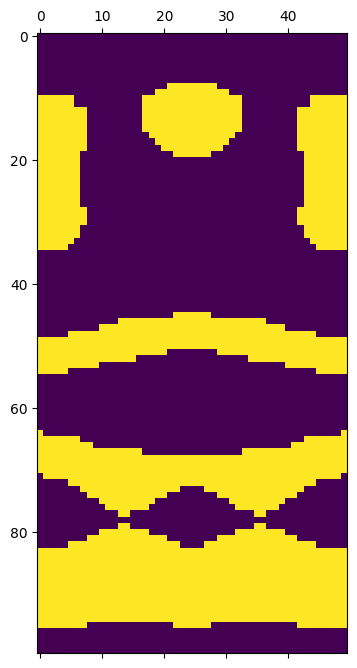

In [10]:
plt.matshow(dataset2[np.random.randint(500)])

In [11]:
dataset2=torch.flatten(dataset2,start_dim=1)

In [12]:
train_dataset2=dataset2[:1000]
test_dataset=dataset2[1000:]

In [13]:
 train_dataset2.shape, test_dataset.shape

(torch.Size([1000, 5000]), torch.Size([406, 5000]))

In [14]:
##FOR IMPLEMENTING STRAIGHT THROUGH BVAE

class binarization(torch.autograd.Function):
    
    @staticmethod
    def forward(self,input):
        a=input.clone()
        a[a>0.5]=torch.tensor([1-(1e-5)])
        a[a<0.5]=torch.tensor([0+1e-5])
        return a

        
    @staticmethod
    def backward(self,grad_output):
        grad_input = grad_output.clone()
        return grad_input
        
        
        

In [15]:
class bVAE(nn.Module):
  def __init__(self,latent_dim):
    super(bVAE, self).__init__()
    
    self.encoder=nn.Sequential(
        nn.Linear(input_size,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(512,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(256,latent_dim),
        nn.Sigmoid(),
    )

    self.decoder=nn.Sequential(
        nn.Linear(latent_dim,256),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(256,512),
        nn.LeakyReLU(0.1),
        nn.Dropout(p=0.2),

        nn.Linear(512,input_size),
        nn.Sigmoid()
    )

  def encode(self,x):
    a= self.encoder(x)
    a=torch.clamp(a,min=1e-5,max=1-1e-5)
    return a

  def gumbel_reparam(self,a,lambd): # takes in the input from the encoder
    lambd=lambd.to(DEVICE)
    a=torch.clamp(a,min=1e-5,max=1-1e-5).to(DEVICE)
    u=torch.clamp(torch.rand(a.size()),min=1e-5,max=1-1e-5).to(DEVICE)
    x=((torch.log(a/(1-a))+torch.log(u/(1-u)))/lambd).to(DEVICE)
    x=torch.sigmoid(x)
    x=torch.clamp(x,min=1e-5,max=1-1e-5)
    return x



  def decode(self,x):
    d=self.decoder(x)
    return d


  def forward(self,x):
    e=self.encode(x)
    g=self.gumbel_reparam(e,lambd)
    b=binarization.apply(g)
    d=self.decode(g)
    return d,b,g,e


In [16]:
#model=torch.load('../input/metagrating2/model_meta2')

Everytime you call load a pretrained model, want to continue training, make surre that the lambda vallue is where you left it at

In [37]:

input_size=5000
latent_dim=500
LEARNING_RATE=1e-3

num_epochs=2000

lambd=torch.Tensor([5.0])
lambd_min=torch.Tensor([0.45])
lambd_learning_rate=torch.Tensor([3e-4])


model=bVAE(latent_dim)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [38]:
#model.load_state_dict(torch.load('../input/meta-dict2/bVAE_state_dict_meta2'))

In [39]:
#lambd=torch.Tensor([5.0])

In [40]:
beta=1


In [41]:


def projection(x, beta=torch.Tensor([32]), eta=torch.Tensor([0.5])):
    
    return (torch.tanh(beta*eta) + torch.tanh(beta*(x-eta))) / (torch.tanh(beta*eta) + torch.tanh(beta*(1-eta)))

In [42]:
bb=torch.Tensor([0.55])
projection(bb)

tensor([0.9608])

In [43]:
def compute_loss(model,x):
    x_hat,bi,gumbell,a=model(x+torch.rand(x.size()).to(DEVICE))
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=F.mse_loss(x,x_hat)
    #loss=nn.BCELoss()
    
    #reconstruction_loss=loss(x_hat,x)
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a)))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss

def compute_loss2(model,x): ### WRONG!!!! CHECK THE AXIS OF KL_LOSS...should be 1
    x_hat,bi,gumbell,a=model(x)
    reconstruction_loss=torch.mean(torch.square(x-x_hat))
    #reconstruction_loss=torch.mean(F.mse_loss(x,x_hat))
    KL_loss=torch.mean(latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=0))
    total_loss=reconstruction_loss+beta*KL_loss
    return total_loss,reconstruction_loss,KL_loss


def compute_loss_batch(model,x, beta=beta):
#!!!!!!!!!#### befor runing check x and x1 always
    x=x.float()
    x1=torch.clamp(x+torch.normal(0.0,std,x.size()).to(DEVICE),0,1)
    x_hat,bi,gumbell,a=model(x1*torch.bernoulli(torch.ones(x.size()).to(DEVICE)*b))
    ####### gaussian filter and projection
    '''
    x_hat=torch.reshape(x_hat, (1000, 100,50))
    x_hat=gaussian_filter(x_hat, sigma=1)
    x_hat=projection(torch.Tensor(x_hat))
    x_hat=torch.reshape(x_hat, (1000, 5000))
    '''
    
    #######
    reconstruction_loss=torch.mean(torch.square(x-x_hat),axis=1) ## next instead of sum, make it mean!!!!!!!!
    #reconstruction_loss= F.binary_cross_entropy(x_hat, x)
    '''
    x_hat=torch.clamp(x_hat,min=1e-3,max=1-1e-3)
    reconstruction_loss=-(x*torch.log(x_hat)+(1-x)*torch.log(1-x_hat))
    reconstruction_loss=torch.mean(reconstruction_loss,axis=1)
    '''
    

    KL_loss=latent_dim*np.log(2) + torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)

    total_loss=torch.mean(reconstruction_loss+beta*KL_loss)
    return total_loss,torch.mean(reconstruction_loss),torch.mean(KL_loss)

In [44]:
#train_dataset2.size()

In [45]:
#x_hat,bi,gumbell,a=model(train_dataset2.to(DEVICE))

In [46]:
#x_hat.shape

torch.Size([1000, 5000])

In [ ]:
#x_hat=torch.reshape(x_hat, (1000, 100,50))

In [ ]:
#plt.matshow(x_hat[1].cpu().detach().numpy())

In [ ]:
#a.size()

In [ ]:
#torch.mean(torch.sum(a*torch.log(a)+(1-a)*torch.log(1-a),axis=1)+latent_dim*np.log(2) )

In [ ]:
#torch.mean((x_hat-train_dataset2.float()),axis=1).size()

In [ ]:
#compute_loss_batch(model,train_dataset2.to(DEVICE)).size()

In [ ]:
t=[]
r=[]
k=[]
ll=[]

In [ ]:


model.train()

for i in range(10):
  for j in train_dataset2:
    start_time = time.time()
    optimizer.zero_grad()
    j=j.to(DEVICE)

    tl,rl,kl=compute_loss(model,j.float())

    t.append(tl)
    r.append(rl)
    k.append(kl)

    tl.backward()
    optimizer.step()
  print('Time for epoch {} is {} sec, Loss: {},{},{} '.format(i + 1, time.time()-start_time,tl,rl,kl))
  if (i%100):
    if lambd>lambd_min:
      lambd=lambd*np.exp(-lambd_learning_rate*i)
      ll.append(lambd)

In [ ]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

In [ ]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

In [ ]:
x=np.arange(len(k))
k=list(map(float,k))
plt.scatter(x,k)

In [ ]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [47]:
t=[]
r=[]
k=[]
n=[]#net loss.....1*rl + 1*kl
ll=[]

In [48]:
#lambd=torch.Tensor([5.0])
beta_values = torch.Tensor([0,1e-7, 1e-6, 1e-5, 1e-4, 1e-3 ]) #for annealing
beta_index=0
beta=beta_values[0]

model.train()
train_dataset2=train_dataset2.to(DEVICE)

for i in range(20000):
    std=0#torch.rand() # ideally 0
    b=1#torch.rand()#ideally 1
    start_time = time.time()
    optimizer.zero_grad()
    

    tl,rl,kl=compute_loss_batch(model,train_dataset2, beta=1e-2)

    t.append(tl)
    r.append(rl)
    k.append(kl)
    n.append(kl+rl)

    tl.backward()
    optimizer.step()
    if (i%1000==0):
        print('Time for epoch {} is {} sec, Loss: TL={},NL={}, RL={},KL={} '.format(i + 1, time.time()-start_time,tl,rl+kl,rl,kl))
        beta=beta_values[beta_index]

        if beta_index == (len(beta_values)-1):
            beta_index = len(beta_values)-1
            
        else:
            beta_index = beta_index + 1
        
    if (i%200==0):
        if lambd>lambd_min:
            lambd=lambd*np.exp(-lambd_learning_rate*i)
            
    ll.append(lambd)

Time for epoch 1 is 0.06312012672424316 sec, Loss: TL=0.2558046281337738,NL=0.8010572195053101, RL=0.25029703974723816,KL=0.5507602095603943 
Time for epoch 1001 is 0.05989694595336914 sec, Loss: TL=0.24501988291740417,NL=0.2454546093940735, RL=0.245015487074852,KL=0.0004391174588818103 
Time for epoch 2001 is 0.05441761016845703 sec, Loss: TL=0.23572485148906708,NL=0.9823638200759888, RL=0.22818303108215332,KL=0.7541807889938354 
Time for epoch 3001 is 0.05581831932067871 sec, Loss: TL=0.2176729291677475,NL=2.547926425933838, RL=0.19413502514362335,KL=2.3537914752960205 
Time for epoch 4001 is 0.05238962173461914 sec, Loss: TL=0.2025773823261261,NL=2.9483237266540527, RL=0.17484256625175476,KL=2.7734811305999756 
Time for epoch 5001 is 0.05593395233154297 sec, Loss: TL=0.1946834921836853,NL=3.7947890758514404, RL=0.15831878781318665,KL=3.636470317840576 
Time for epoch 6001 is 0.05601310729980469 sec, Loss: TL=0.18361873924732208,NL=4.2811665534973145, RL=0.142229363322258,KL=4.138936

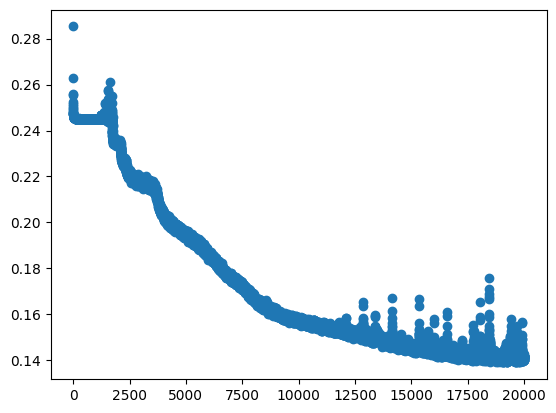

In [49]:
x=np.arange(len(t))
t=list(map(float, t))
plt.scatter(x,t)

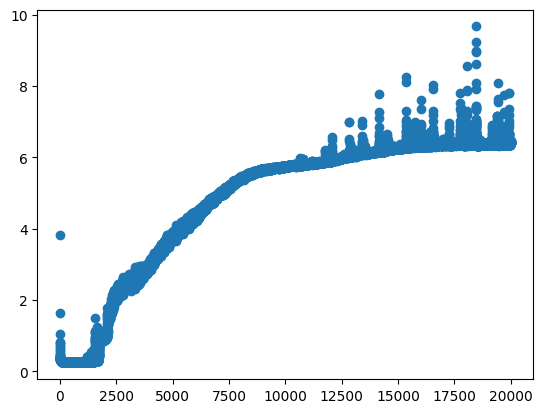

In [50]:
x=np.arange(len(n))
n=list(map(float, n))
plt.scatter(x,n)

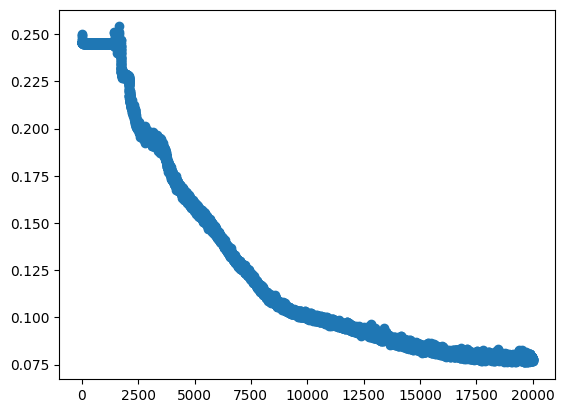

In [51]:
x=np.arange(len(r))
r=list(map(float, r))
plt.scatter(x,r)

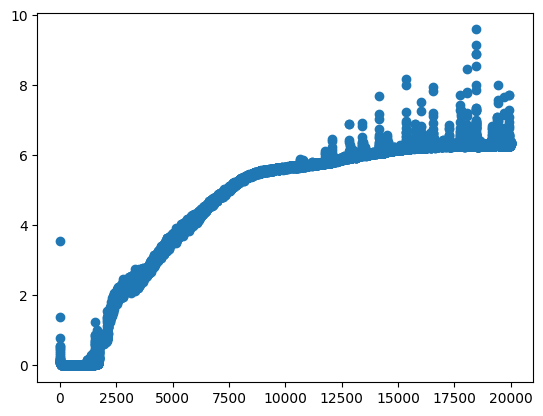

In [52]:
x=np.arange(len(k))
k=list(map(float, k))
plt.scatter(x,k)

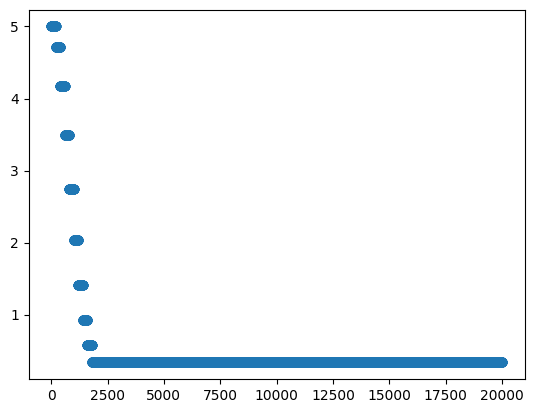

In [53]:
x=np.arange(len(ll))
ll=list(map(float, ll))
plt.scatter(x,ll)

In [54]:
model.eval()

bVAE(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=500, bias=True)
    (7): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.1)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=512, out_features=5000, bias=True)
    (7): Sigmoid()
  )
)

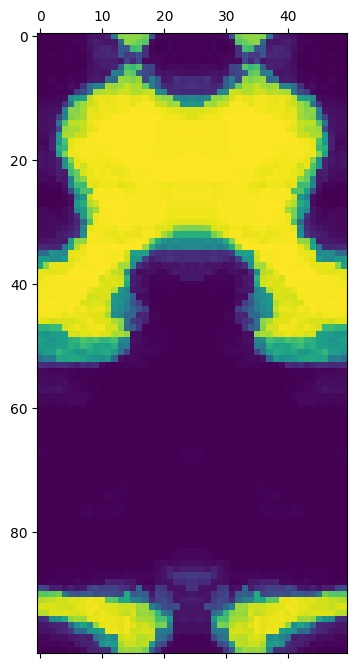

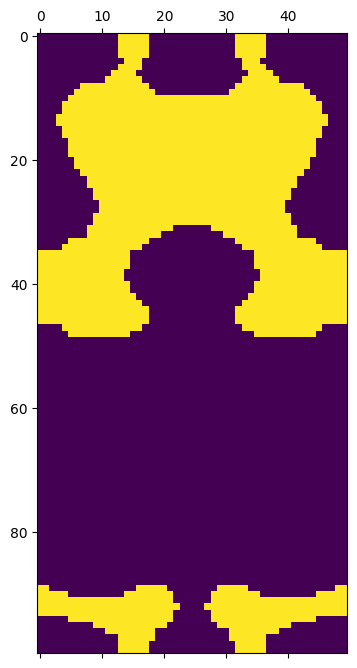

In [61]:
x=train_dataset2[np.random.randint(500)]
y=model(x.float().to(DEVICE))[0]
y=y.cpu().detach().numpy()
y=np.reshape(y,(100,50))
plt.matshow(y)

x1=x

x1=x1.cpu().detach().numpy()
plt.matshow(x1.reshape((100,50)))

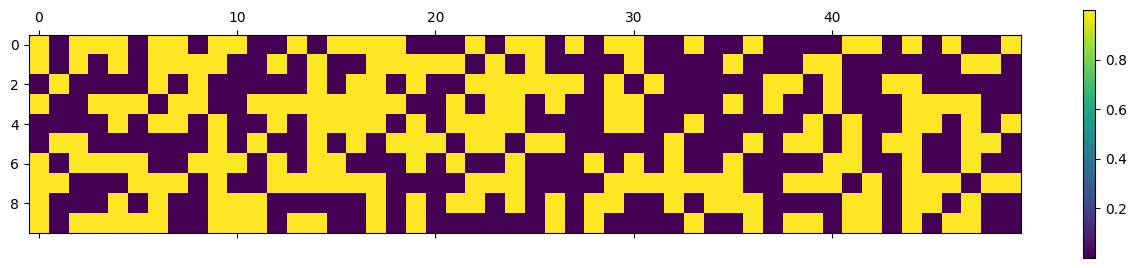

In [56]:
b=model(x.float().to(DEVICE))[1]
b=b.cpu().detach().numpy()
b=np.reshape(b,(10,50))
plt.matshow(b)
plt.colorbar()

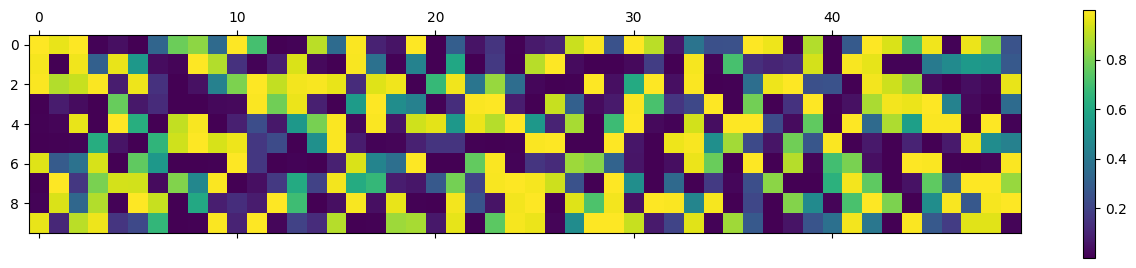

In [57]:
g=model(x.float().to(DEVICE))[2]
g=g.cpu().detach().numpy()
g=np.reshape(g,(10,50))
plt.matshow(g)
plt.colorbar()

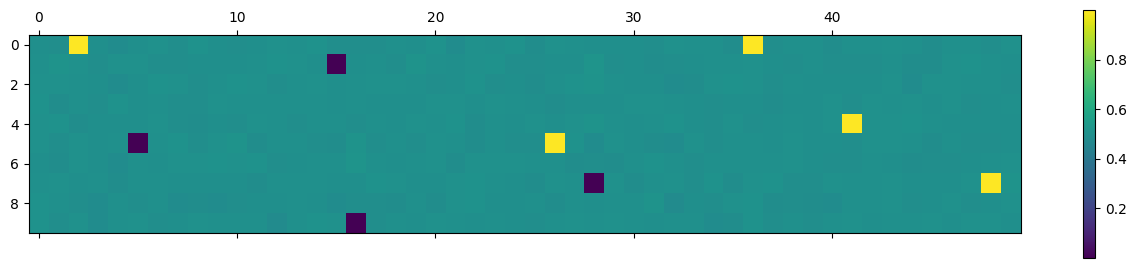

In [58]:
a=model(x.float().to(DEVICE))[3]
a=a.cpu().detach().numpy()
a=np.reshape(a,(10,50))
plt.matshow(a)
plt.colorbar()

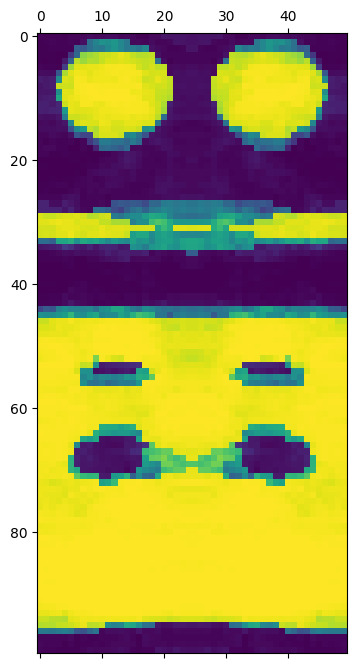

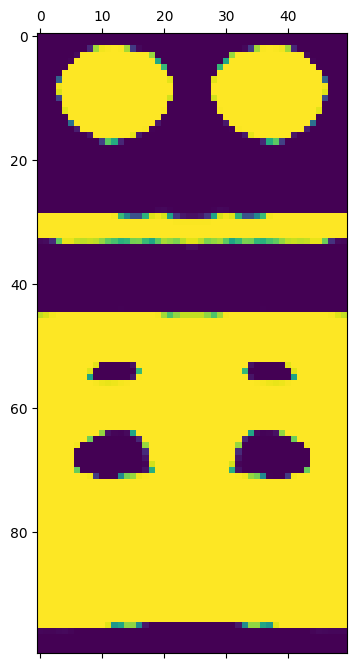

In [83]:
a_check=torch.rand((latent_dim,))
decoder_input=torch.bernoulli(a_check) .to(DEVICE)
output=model.decode(decoder_input)

output=output.cpu().detach().numpy()
output=np.reshape(output,(100,50))


#output[output>0.1]=1
#output[output<0.1]=0
plt.matshow(output)


output=gaussian_filter(output, sigma=1)
output=projection(torch.Tensor(output))
plt.matshow(output)

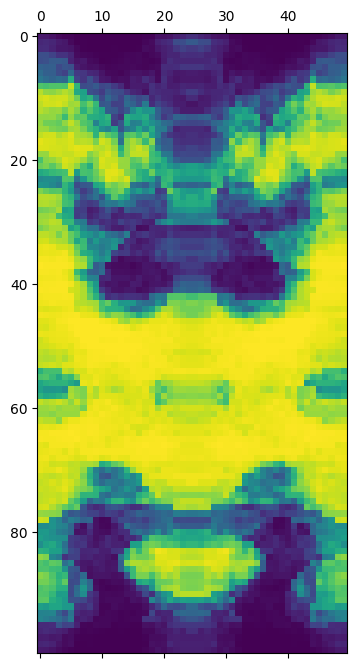

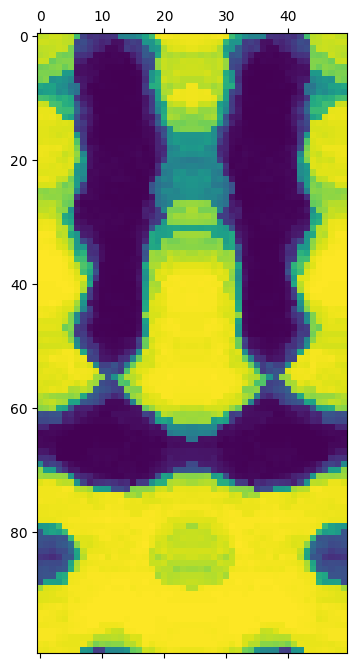

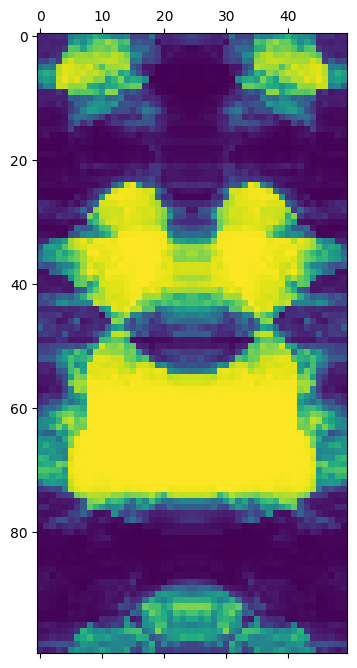

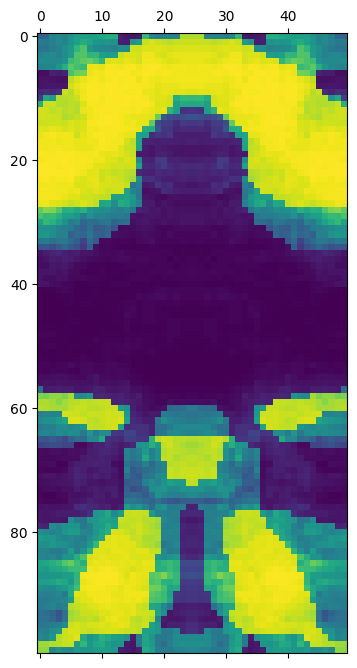

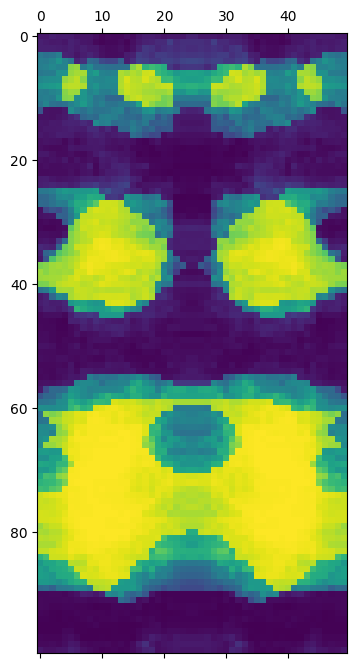

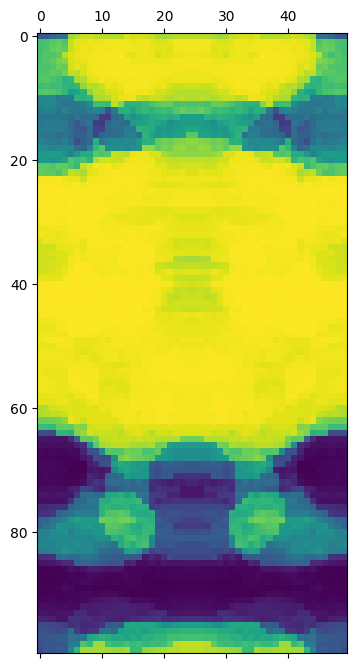

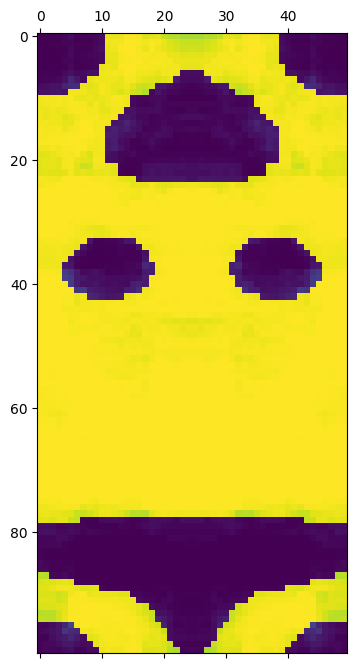

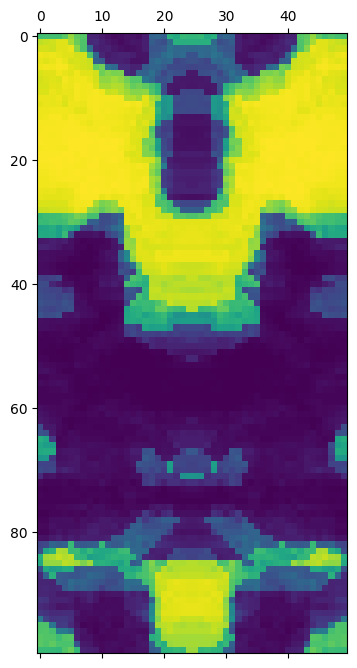

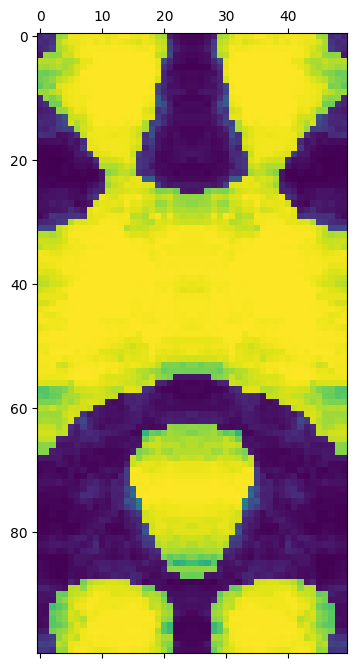

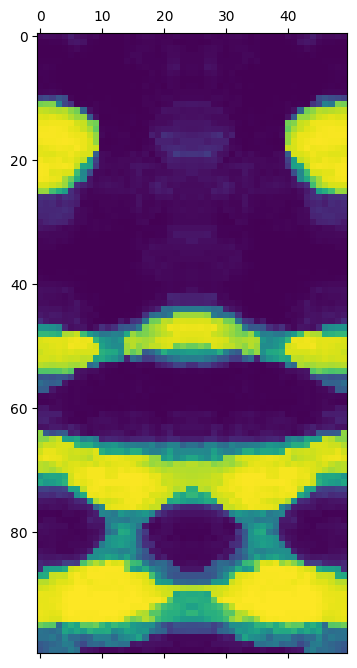

In [87]:
for i in range(10):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(100,50))
    #output=gaussian_filter(output, sigma=1)
    #output=projection(torch.Tensor(output))

    #output[output>0.1]=1
    #output[output<0.1]=0
    plt.matshow(output)

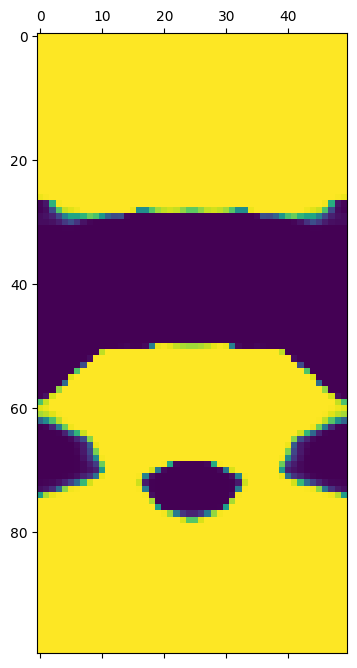

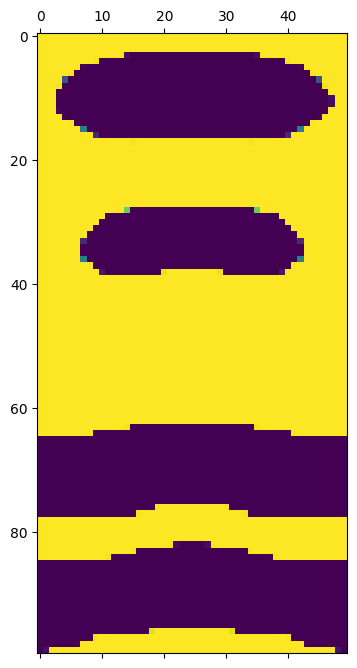

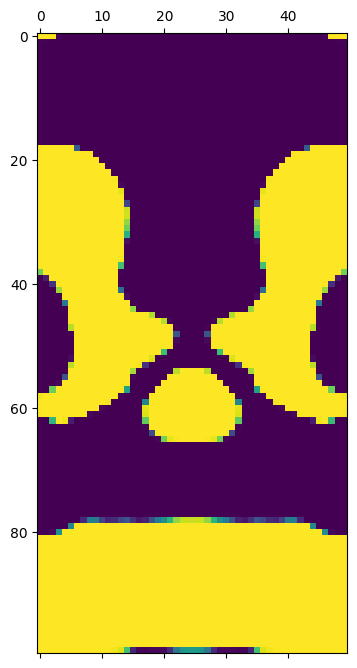

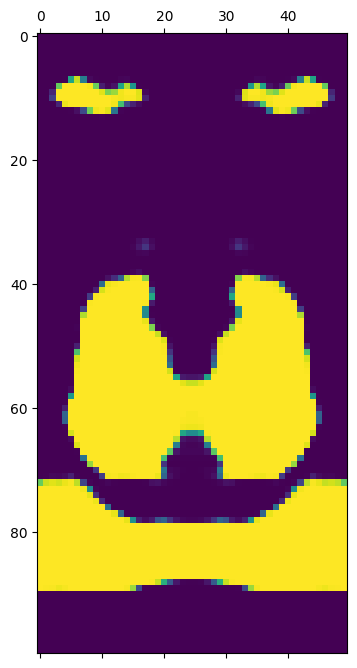

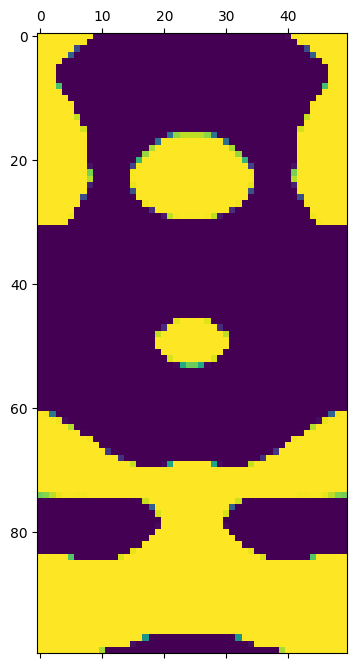

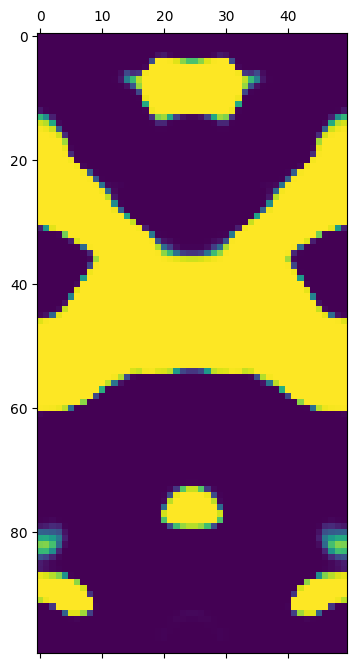

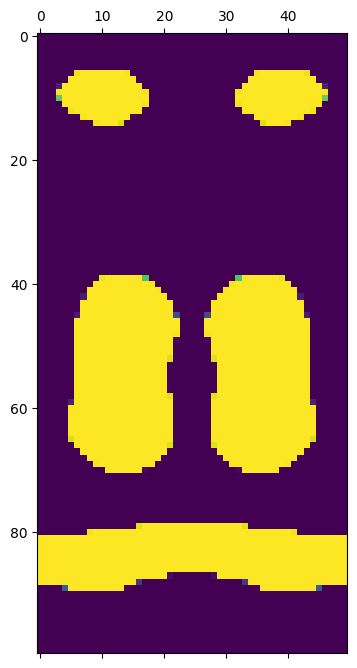

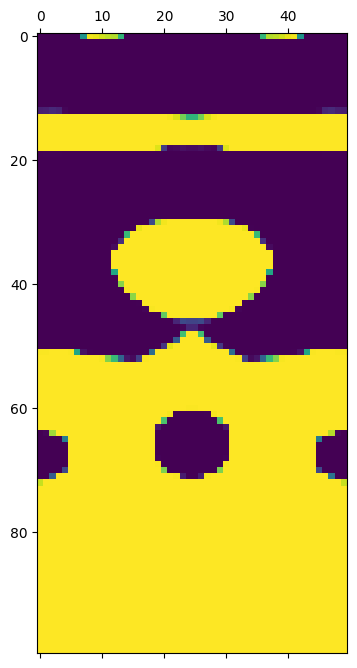

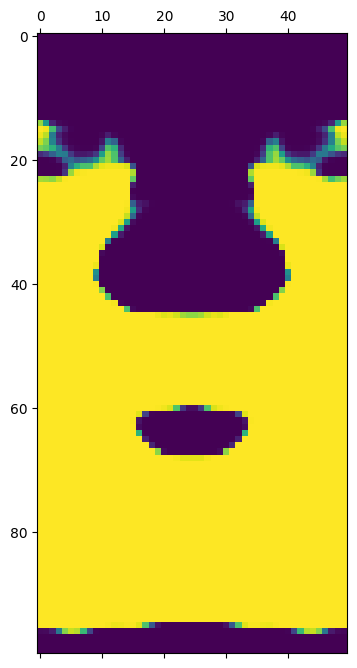

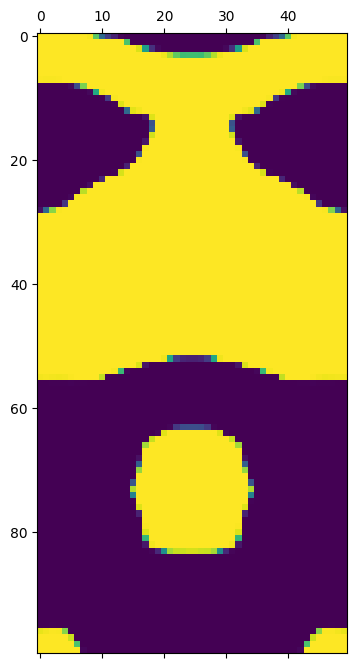

In [88]:
#better results with gaussian blur and projection
for i in range(10):
    a_check=torch.rand((latent_dim,))
    decoder_input=torch.bernoulli(a_check) .to(DEVICE)
    output=model.decode(decoder_input)
    
    output=output.cpu().detach().numpy()
    output=np.reshape(output,(100,50))
    output=gaussian_filter(output, sigma=1)
    output=projection(torch.Tensor(output))

    #output[output>0.1]=1
    #output[output<0.1]=0
    plt.matshow(output)

In [ ]:
a_check=torch.rand((latent_dim,))
decoder_input=torch.bernoulli(a_check) .to(DEVICE)

In [ ]:
decoder_input[1:100]=0

In [ ]:


output=model.decode(decoder_input)

output=output.cpu().detach().numpy()
output=np.reshape(output,(100,500))
#output[output>0.5]=1
#output[output<0.5]=0
plt.matshow(output)

In [ ]:
model(x.float().to(DEVICE))

In [ ]:
torch.save(model.state_dict(),'bVAE_state_dict_noise1')

In [ ]:
torch.save(model, 'model_meta_meta_noise1')